In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone 
from sklearn import tree
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt 

In [2]:
class ThreesandEights:
    def __init__(self, location):
        import pickle, gzip
        # Load the dataset
        f = gzip.open(location, 'rb')

        # Split the data set 
        x_train, y_train, x_test, y_test = pickle.load(f)
                
        # Extract only 3's and 8's for training set 
        self.x_train = x_train[np.logical_or(y_train== 3, y_train == 8), :]
        self.y_train = y_train[np.logical_or(y_train== 3, y_train == 8)]
        self.y_train = np.array([1 if y == 8 else -1 for y in self.y_train])
        
        # Shuffle the training data 
        shuff = np.arange(self.x_train.shape[0])
        np.random.shuffle(shuff)
        self.x_train = self.x_train[shuff,:]
        self.y_train = self.y_train[shuff]

        # Extract only 3's and 8's for validation set 
        self.x_test = x_test[np.logical_or(y_test== 3, y_test == 8), :]
        self.y_test = y_test[np.logical_or(y_test== 3, y_test == 8)]
        self.y_test = np.array([1 if y == 8 else -1 for y in self.y_test])        
        f.close()

def view_digit(ex, y, feature=None):
    if y == 1:
        label = '8'
    else:
        label = '3'
    print("true label: {}".format(label))
    img = ex.reshape(21,21)
    col = np.dstack((img, img, img))
    if feature is not None: col[feature[0]//21, feature[0]%21, :] = [1, 0, 0]
    plt.figure(figsize=(5,3))
    plt.imshow(col)
    plt.xticks([]), plt.yticks([])
    
data = ThreesandEights("mnist21x21_3789.pklz")

true label: 8


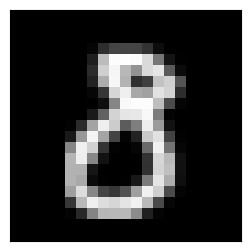

In [32]:
view_digit(data.x_train[0], data.y_train[0])

true label: 3


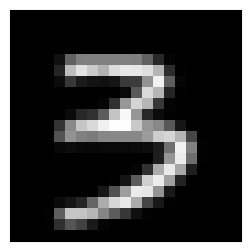

In [34]:
view_digit(data.x_train[100], data.y_train[100])

In [3]:
from copy import deepcopy

class AdaBoost:
    def __init__(self, n_learners=20, base=DecisionTreeClassifier(max_depth=3), random_state=1234):   
        np.random.seed(42)        
        self.n_learners = n_learners 
        self.base = base
        self.alpha = np.zeros(self.n_learners)
        self.learners = []

    def fit(self, X_train, y_train):
        n = len(y_train)
        w = np.ones(n, dtype=np.float64)
        w /= np.sum(w)
        for i in range(self.n_learners):
            h = clone(self.base)
            h.fit(X_train, y_train, sample_weight=w)
            y_pred = h.predict(X_train)            
            error = self.error_rate(y_train, y_pred, w)            
            alpha = 0.5 * np.log((1 - error)/error)            
            w *= np.exp(-alpha * y_pred * y_train)
            w /= np.sum(w)            
            self.alpha[i] = alpha
            self.learners.append(h)
        return self   
    
    def error_rate(self, y_true, y_pred, weights):
        n = len(y_true)
        indicator = np.array([0 if y_pred[i] == y_true[i] else 1 for i in range(n)])
        err = np.sum(weights * indicator) / np.sum(weights)
        return err   
    
    def predict(self, X):
        tree_preds = np.array([self.alpha[i] * h.predict(X) for i, h in enumerate(self.learners)])      
        y_pred = np.sum(tree_preds, axis=0)
        y_pred = np.sign(y_pred)
        return y_pred
    
    def score(self, X, y):
        y_pred = self.predict(X)
        acc = np.sum(y_pred == y) / len(y)
        return acc      
    
    def staged_score(self, X, y):
        stage_score = np.zeros(self.n_learners)
        ab_learners = deepcopy(self.learners)
        num_learners = self.n_learners
        for i in range(num_learners):
            self.learners = ab_learners[:(i+1)]
            self.n_learners = (i+1)
            stage_score[i] = self.score(X, y)              
        return stage_score        

In [23]:
clf = AdaBoost(n_learners=400, base=DecisionTreeClassifier(max_depth=1))
clf.fit(data.x_train, data.y_train)

In [24]:
staged_score_train = clf.staged_score(data.x_train, data.y_train)
staged_score_test = clf.staged_score(data.x_test, data.y_test)
error_trainAda = np.array([(1-score) for score in staged_score_train])
error_testAda = np.array([(1-score) for score in staged_score_test])

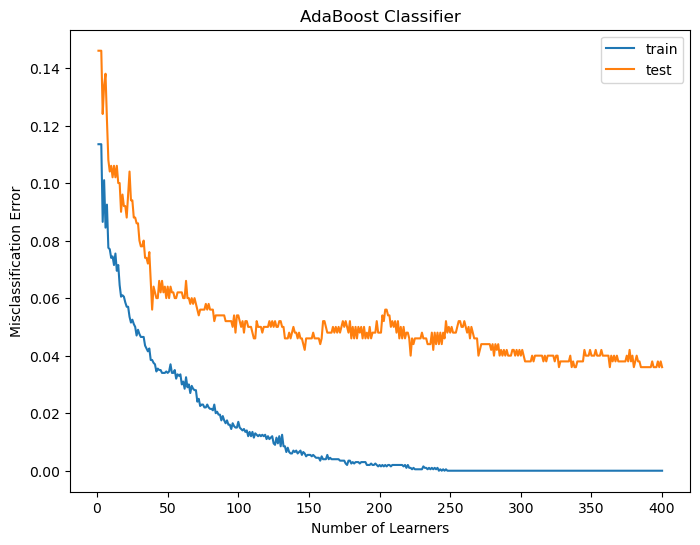

In [25]:
num_learners = np.arange(1, 401)
plt.figure(figsize=(8, 6))
plt.plot(num_learners, error_trainAda, label='train')
plt.plot(num_learners, error_testAda, label='test')
plt.xlabel('Number of Learners')
plt.ylabel('Misclassification Error')
plt.title('AdaBoost Classifier')
plt.legend();

In [29]:
from collections import Counter

class RandomForest():    
    def __init__(self, x, y, sample_sz, n_trees=200, n_features='sqrt', max_depth=10, min_samples_leaf=5):
        np.random.seed(42)
        if n_features == 'sqrt':
            self.n_features = int(np.sqrt(x.shape[1]))
        elif n_features == 'log2':
            self.n_features = int(np.log2(x.shape[1]))
        else:
            self.n_features = n_features
        print(self.n_features, "sha: ",x.shape[1])
        
        self.features_set = []        
        self.x = x
        self.y = y
        self.sample_sz = sample_sz
        self.max_depth = max_depth
        self.min_samples_leaf  = min_samples_leaf
        self.trees = [self.create_tree(i) for i in range(n_trees)]
        
    def create_tree(self,i):      
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        idxs = np.asarray(idxs)

        f_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        f_idxs = np.asarray(f_idxs)
                
        if i==0:
            self.features_set = np.array(f_idxs, ndmin=2)     # ndmin: Specifies the minimum number of dimensions  
        else:
            self.features_set = np.append(self.features_set, np.array(f_idxs,ndmin=2),axis=0)
            
        clf = DecisionTreeClassifier(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
        x = self.x[idxs, ][:, f_idxs]
        y = self.y[idxs]
        clf.fit(x, y)       
        return clf       
    
    def predict(self, x):       
        tree_preds = []
        for i, tree in enumerate(self.trees):
            X = x[:, ][:, self.features_set[i]]
            preds = tree.predict(X)
            tree_preds.append(preds)
              
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = np.array([self.most_common_label(yi) for yi in tree_preds])       
        return y_pred        
    
    def most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common    
    
    def score(self, X, y):        
        y_pred = self.predict(X)
        acc = np.sum(y == y_pred) / len(y)
        return acc

In [31]:
rf = RandomForest(data.x_train, data.y_train, sample_sz=1500)
misclfy_err = 1 - rf.score(data.x_test, data.y_test)
print('Misclassification error on test data : %0.3f'%misclfy_err)

21 sha:  441
Misclassification error on test data : 0.040


In [26]:
n_trees = np.arange(1, 401)
m = len(n_trees)
error_train = []
error_test = []

for i in range(m):
    rf = RandomForest(data.x_train, data.y_train, sample_sz=1500, n_trees=n_trees[i])
    err_train = 1 - rf.score(data.x_train, data.y_train)
    err_test = 1 - rf.score(data.x_test, data.y_test)
    error_train.append(err_train)
    error_test.append(err_test)  

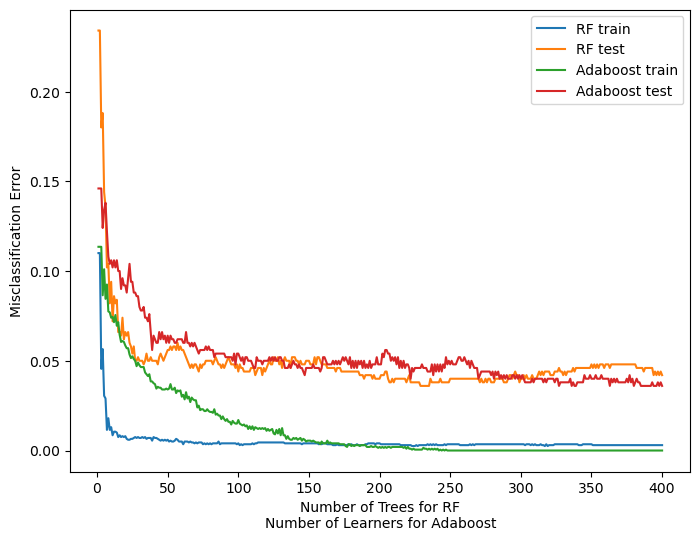

In [28]:
plt.figure(figsize=(8, 6))
plt.plot(n_trees, error_train, label='RF train')
plt.plot(n_trees, error_test, label='RF test')
plt.plot(num_learners, error_trainAda, label='Adaboost train')
plt.plot(num_learners, error_testAda , label='Adaboost test')
plt.xlabel('Number of Trees for RF\nNumber of Learners for Adaboost')
plt.ylabel('Misclassification Error')
plt.legend();